In [1]:
import numpy as np
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

_DEBUG = True

def make_index():
    # Explore the raw folder and build a pandas frame with relevant run informations
    hashes = get_immediate_subdirectories('raw')
    all_keys = set()
    dict_of_dicts = {}

    for hash in hashes:
        with open('raw/{}/params'.format(hash), 'r') as outfile:
            params = json.load(outfile)
        dict_of_dicts[hash] = params

    database = pd.DataFrame.from_dict(dict_of_dicts).transpose()
    database.to_pickle('raw/parameters_database.pkl')
    database.to_string(open('raw/parameters_database_human_readable.txt', mode='w+'))
    database.to_csv(open('raw/parameters_database.csv', mode='w+'))
    print('Current index table : {}'.format(database))

def check_integrity(folder):
    try:
        with open('{}/exited_naturally'.format(folder), 'r') as f:
            pass
    except FileNotFoundError:
        print('Folder {} did not exit naturally, skip it'.format(folder))


def make_average_energy(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    train_energy_blob = np.zeros((n_seeds, t_max//test_every+1))
    test_energy_blob = np.zeros((n_seeds, t_max // test_every + 1))

    for seed in range(n_seeds):
        train_energy_blob[seed] = np.load('{}/seed_{}/train_energy_acc.npy'.format(folder, seed))
        test_energy_blob[seed] = np.load('{}/seed_{}/test_energy_acc.npy'.format(folder, seed))

    train_mean = np.mean(train_energy_blob, axis=0)[1:]
    train_std = np.std(train_energy_blob, axis=0)[1:]

    test_mean = np.mean(test_energy_blob, axis=0)[1:]
    test_std = np.std(test_energy_blob, axis=0)[1:]

    np.save('{}/E_train_avg.npy'.format(folder), train_mean)
    np.save('{}/E_train_std.npy'.format(folder), train_std)

    np.save('{}/E_test_avg.npy'.format(folder), test_mean)
    np.save('{}/E_test_std.npy'.format(folder), test_std)


    plt.figure()
    plt.title(folder.split('/')[-1])
    plt.errorbar(np.arange(0, t_max, test_every), train_mean, yerr=train_std, label='Train')
    plt.errorbar(np.arange(0, t_max, test_every), test_mean, yerr=test_std, label='Test')
    plt.legend()
    plt.savefig('{}/energies.png'.format(folder))
    plt.close()


def make_average_mu(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    mu_blob = np.zeros((n_seeds, t_max//test_every+1))


    for seed in range(n_seeds):
        mu_blob[seed] = np.load('{}/seed_{}/mu_acc.npy'.format(folder, seed))


    mu_mean = np.mean(mu_blob, axis=0)[1:]
    mu_std = np.std(mu_blob, axis=0)[1:]

    np.save('{}/mu_avg.npy'.format(folder), mu_mean)
    np.save('{}/mu_std.npy'.format(folder), mu_std)

    plt.figure()
    plt.title(folder.split('/')[-1])
    plt.errorbar(np.arange(0, t_max, test_every), mu_mean, yerr=mu_std)
    plt.savefig('{}/mus.png'.format(folder))
    plt.close()



def make_eigenvalues_diffmap(folder):
    check_integrity(folder)

    with open('{}/params'.format(folder), 'r') as outfile:
        dict = json.load(outfile)
        N = dict['n_neurons']
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']

    eigenvalues_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    mu_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    for seed in range(n_seeds):
        eigenvalues_blob[:, :, seed] = np.load('{}/seed_{}/eigenvalues_acc.npy'.format(folder, seed))
        mu_blob[:, :, seed] = np.repeat(np.load('{}/seed_{}/mu_acc.npy'.format(folder, seed)).reshape(-1, 1), N, axis=1)


    if _DEBUG:
        for t in range(1, 10):
            print(eigenvalues_blob[-t, :, 0].max().item(), eigenvalues_blob[-t, :, 0].min().item(), mu_blob[-t, 0, 0], mu_blob[-t, -1, 0], eigenvalues_blob[-t, :, 0].mean().item())

    eigenvalues_blob = mu_blob - eigenvalues_blob

    if _DEBUG:
        for t in range(1, 10):
            print(eigenvalues_blob[-t, :, 0].max().item(), eigenvalues_blob[-t, :, 0].min().item(), eigenvalues_blob[-t, :, 0].mean().item())


    # Make a "diffusion map" for the eigenvalues
    n_bins = 1000
    grouping = 10
    v_min, v_max = -5., 5.

    mixed_evs = np.clip(eigenvalues_blob.reshape(eigenvalues_blob.shape[0], -1), v_min, v_max)
    # print(np.min(mixed_evs), np.max(mixed_evs))
    # print(np.sum(mixed_evs == 0), np.sum(mixed_evs == 1.5))
    bounds = [v_min, v_max]
    diff_map = np.zeros((eigenvalues_blob.shape[0] // grouping +1, n_bins))

    for t in range(eigenvalues_blob.shape[0]):
        for ev in mixed_evs[t]:
            diff_map[t // grouping, int((n_bins-1) * (ev-bounds[0]) / (bounds[1] - bounds[0]))] += 1.

    for t in range(diff_map.shape[0]):
        diff_map[t] /= np.sum(diff_map[t])

    plt.figure()
    plt.imshow(diff_map[-100:].T, origin='lower', extent=[0, t_max, bounds[0], bounds[1]], aspect='auto')
    plt.title(folder.split('/')[-1])
    plt.savefig('{}/eigenvalues_diffmap.png'.format(folder))
    plt.close()



def parse_individual_subfolder(subfolder):
    # This function only acts as a container for other analysis routines (to keep things readable and modular)

    make_average_energy(subfolder)
    make_average_mu(subfolder)
    make_eigenvalues_diffmap(subfolder)



def post_run_parsing():
    make_index()
    exp_dirs = get_immediate_subdirectories('raw')
    for exp_dir in exp_dirs:
        print('Treating folder {}'.format(exp_dir))
        parse_individual_subfolder('raw/' + exp_dir)

post_run_parsing()

Current index table :                  alpha  beta beta_normalized gamma n_neurons n_samples  \
04336da277f609bd     0  2500               1     2        50         0   
04703120a401c0df    10  2500               1     0        50       500   
06fc33200b7de500     0  2500               1   3.5        50         0   
16a3691dc787dc40   100  2500               1    40        50       500   
17997e81004cbb60     0  2500               1   0.5        50         0   
1a6d744921e6d990  1000  2500               1    40        50       500   
1c3fab45577185af     1  2500               1    40        50       500   
4d750eac11233d0e    10  2500               1    10        50       500   
4f50cd188d8ed3f3    10  2500               1   100        50       500   
51fa63eedf5712ea    10  2500               1  1000        50       500   
6d2a3f0d2afeb11f     3  2500               1    40        50       500   
750bd4077fd03f5a    10  2500               1   100        50       500   
7dd0a314a0296953

Treating folder 04703120a401c0df
0.5609405636787415 -0.7116134166717529 1.1048391499631542 1.1048391499631542 -1.2889504432678223e-08
0.5821506381034851 -0.6920625567436218 1.1075192311198037 1.1075192311198037 7.823109626770019e-10
0.5559918284416199 -0.685072660446167 1.106038316977618 1.106038316977618 -1.0244548320770264e-08
0.5647355318069458 -0.7155780792236328 1.1077761149155956 1.1077761149155956 4.284083843231201e-09
0.5623465776443481 -0.7044231295585632 1.1078651808393585 1.1078651808393585 -2.598389983177185e-09
0.5727511048316956 -0.7162098288536072 1.1081741505075304 1.1081741505075304 3.166496753692627e-10
0.5893489122390747 -0.6828590631484985 1.1088826095261521 1.1088826095261521 -1.1734664440155029e-08
0.5707554817199707 -0.7007840871810913 1.107271167024919 1.107271167024919 -1.2377277016639709e-08
0.5633761286735535 -0.7004784345626831 1.1055310407395453 1.1055310407395453 -7.944181561470031e-09
1.8164525666349072 0.5438985862844128 1.1048391628526586
1.799581787863

Treating folder 51fa63eedf5712ea
0.16340793669223785 -0.16312913596630096 1.0021749205241333 1.0021749205241333 -4.190951585769653e-11
0.15480899810791016 -0.1567525714635849 1.001850909556443 1.001850909556443 -3.0500814318656923e-10
0.1456323117017746 -0.14599604904651642 1.0019064926265384 1.0019064926265384 -3.8649886846542357e-10
0.07660083472728729 -0.07631862908601761 1.0011075155587839 1.0011075155587839 -5.855690687894821e-10
0.07063765823841095 -0.06880843639373779 1.0009600584219251 1.0009600584219251 0.0
0.1418192982673645 -0.14141845703125 1.001519657576631 1.001519657576631 1.2450618669390679e-09
0.06106846407055855 -0.06769043952226639 1.0009248860720439 1.0009248860720439 -1.230509951710701e-09
0.11444654315710068 -0.11368978023529053 1.0013914761859495 1.0013914761859495 -7.55535438656807e-10
0.07985246181488037 -0.07153305411338806 1.0012562878991367 1.0012562878991367 3.451714292168617e-10
1.1653040564904342 0.8387669838318954 1.0021749205660428
1.1586034810200279 0.

Treating folder 8210e25caf0e5e64
0.30224838852882385 -0.2769891321659088 1.023914772810673 1.023914772810673 -9.96515154838562e-10
0.30283698439598083 -0.285739928483963 1.0245774909407108 1.0245774909407108 -4.962203092873097e-10
0.3019763231277466 -0.3135223984718323 1.0254095285635036 1.0254095285635036 3.4039840102195738e-09
0.6926506161689758 -0.6953637003898621 1.051240988605947 1.051240988605947 -9.131617844104767e-09
0.31083616614341736 -0.28860145807266235 1.02444774756917 1.02444774756917 2.7008354663848875e-10
0.3040584325790405 -0.28930413722991943 1.024614639035743 1.024614639035743 3.124005161225796e-09
0.31092700362205505 -0.31599485874176025 1.026098215358288 1.026098215358288 3.1478703022003173e-09
0.2966969609260559 -0.2909958064556122 1.0245001969507377 1.0245001969507377 -5.4761767387390136e-09
0.29573774337768555 -0.2928374111652374 1.0241005017158755 1.0241005017158755 4.4284388422966e-09
1.3009039049765818 0.7216663842818491 1.0239147738071879
1.3103174194246738 

In [2]:
def get_siblings(ref_hash, traversal_key):
    # Take the hash of a reference experiment and return list of hashes such that only 'traversal_key' differs
    db = pd.read_pickle('raw/parameters_database.pkl')
    all_keys = list(db.keys())
    hashes = db.index.values.tolist()
    siblings = []
    values = []

    with open('raw/{}/params'.format(ref_hash), 'r') as outfile:
        ref_params = json.load(outfile)

    for hash in hashes:
        is_sibling = True
        with open('raw/{}/params'.format(hash), 'r') as outfile:
            params = json.load(outfile)
        for key in all_keys:
            if params[key] != ref_params[key] and key not in [traversal_key, 't_max', 'n_threads', 'n_seeds', 'test_every']:
                is_sibling = False
                break
        if is_sibling:
            siblings.append(hash)
            values.append(params[traversal_key])

    # Correctly sort the directories in increasing values of the param
    sorter = np.argsort(values)

    siblings = np.array(siblings)[sorter]
    values = np.array(values)[sorter]

    print('To vary parameter {} in {}, visit {}'.format(traversal_key, values, siblings))


    return siblings, values
    
hashs, params = get_siblings('8210e25caf0e5e64', 'alpha')

To vary parameter alpha in [1.e-01 1.e+00 3.e+00 1.e+02 1.e+03], visit ['8210e25caf0e5e64' '1c3fab45577185af' '6d2a3f0d2afeb11f'
 '16a3691dc787dc40' '1a6d744921e6d990']


In [3]:
import matplotlib.pyplot as plt


def theoretical_rho(x):
    return np.sqrt(x * (L-x))

def theoretical_mu_null_alpha(gamma):
    return 0.5 * np.sqrt(gamma) * ((np.sqrt(gamma)**(-1) + np.sqrt(2)) ** 2)

Treating folder 8210e25caf0e5e64 with alpha = 0.1


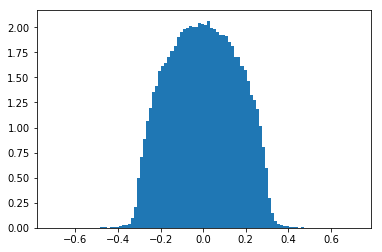

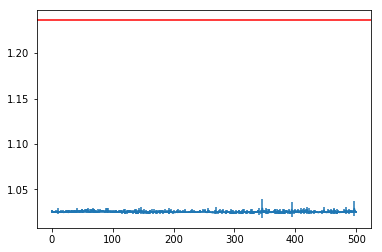

Treating folder 1c3fab45577185af with alpha = 1.0


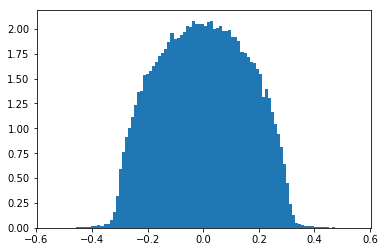

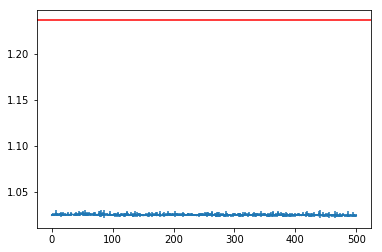

Treating folder 6d2a3f0d2afeb11f with alpha = 3.0


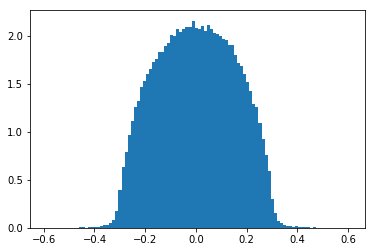

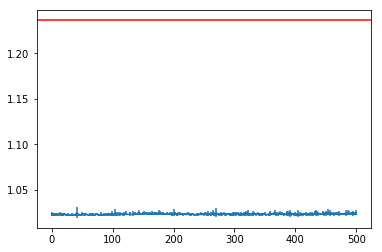

Treating folder 16a3691dc787dc40 with alpha = 100.0


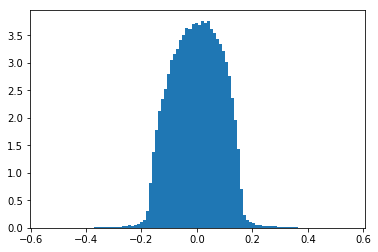

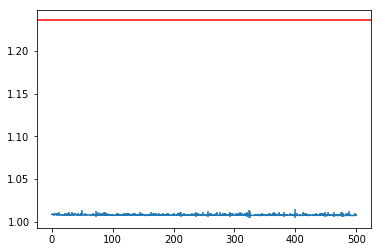

Treating folder 1a6d744921e6d990 with alpha = 1000.0


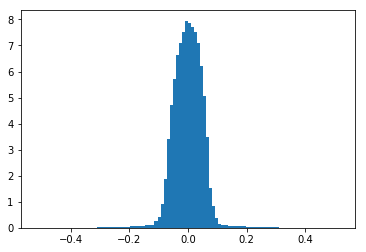

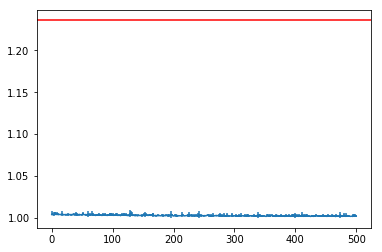

In [4]:
for path, alpha in zip(hashs, params):
    print('Treating folder {} with alpha = {}'.format(path, alpha))
    
    with open('raw/{}/params'.format(path), 'r') as outfile:
        dict = json.load(outfile)
        N = dict['n_neurons']
        n_seeds = dict['n_seeds']
        t_max = dict['t_max']
        test_every = dict['test_every']
        gamma = dict['gamma']

    eigenvalues_blob = np.zeros((t_max // test_every + 1, N, n_seeds))
    mu_blob = np.zeros((t_max // test_every + 1, n_seeds))
    for seed in range(n_seeds):
        eigenvalues_blob[:, :, seed] = np.load('raw/{}/seed_{}/eigenvalues_acc.npy'.format(path, seed))
        mu_blob[:, seed] = np.load('raw/{}/seed_{}/mu_acc.npy'.format(path, seed))
    
    # Discard the first half of the values for each run
    eigenvalues_blob = eigenvalues_blob[len(eigenvalues_blob) // 2:].flatten()
    mu_mean = mu_blob[len(mu_blob)//2:].mean(axis=1)
    mu_std = mu_blob[len(mu_blob)//2:].std(axis=1)
    

    
    plt.figure()
    plt.hist(eigenvalues_blob, density=True, bins=100)
    plt.show()
    
    plt.figure()
    plt.errorbar(x=range(len(mu_mean)), y=mu_mean, yerr=mu_std)
    plt.axhline(y=theoretical_mu_null_alpha(gamma) / np.sqrt(gamma), c='r')
    plt.show()